# Regresi√≥n Log√≠stica

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import cProfile
import pstats
from memory_profiler import memory_usage

#### Leer los datos

In [2]:
# Leer los datos
df = pd.read_csv("train.csv")

# Selecci√≥n de variables
variables_numericas = [
    'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF',
    '1stFlrSF', 'FullBath', 'YearBuilt', 'KitchenAbvGr',
    'TotRmsAbvGrd', 'Fireplaces', 'SalePrice'
]
df = df[variables_numericas]

#### Clasificaci√≥n de Precios

In [3]:
# Clasificaci√≥n de precios
p40 = df['SalePrice'].quantile(0.40)
p90 = df['SalePrice'].quantile(0.90)

def clasificar_precio(precio):
    if precio <= p40:
        return "Econ√≥mica"
    elif precio <= p90:
        return "Intermedia"
    else:
        return "Cara"

#### Variables Dicot√≥micas

In [4]:
df['CategoriaPrecio'] = df['SalePrice'].apply(clasificar_precio)

In [5]:
df['Es_Cara'] = (df['CategoriaPrecio'] == 'Cara').astype(int)
df['Es_Economica'] = (df['CategoriaPrecio'] == 'Econ√≥mica').astype(int)
df['Es_Intermedia'] = (df['CategoriaPrecio'] == 'Intermedia').astype(int)

#### Varables predictoras y divisi√≥n de datos

In [6]:
# Definir las variables predictoras
X = df.drop(columns=['SalePrice', 'CategoriaPrecio', 'Es_Cara', 'Es_Economica', 'Es_Intermedia'])

#### Funci√≥n de Entrenamiento para Regresi√≥n Log√≠stica

In [7]:
def entrenar_modelo_binario(y, nombre_clase, umbral):
    # Divisi√≥n entrenamiento-prueba
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, train_size=0.7, random_state=42, stratify=y
    )

    # Entrenar modelo con scikit-learn
    modelo = LogisticRegression(solver='liblinear')
    modelo.fit(X_train, y_train)

    # Predicciones
    y_proba = modelo.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= umbral).astype(int)

    # M√©tricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cv = cross_val_score(modelo, X, y, cv=5, scoring='accuracy')

    # Calcular AIC y BIC usando statsmodels
    X_test_const = sm.add_constant(X_test)
    modelo_sm = sm.Logit(y_test, X_test_const).fit(disp=False)
    aic = modelo_sm.aic
    bic = modelo_sm.bic

    # Resultados
    print(f"\n--- Resultados para casas {nombre_clase.lower()} ---")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precisi√≥n: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"Precisi√≥n promedio (validaci√≥n cruzada): {cv.mean():.2f}")
    print(f"\nüìä AIC y BIC para casas {nombre_clase.capitalize()}")
    print("--------------------------------------------------")
    print(f"AIC: {aic:.2f}")
    print(f"BIC: {bic:.2f}")

    # Matriz de confusi√≥n
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicci√≥n")
    plt.ylabel("Valor Real")
    plt.title(f"Matriz de Confusi√≥n - Casas {nombre_clase.capitalize()}")
    plt.show()


#### Entrenamiento por Clase


--- Resultados para casas caras ---
Accuracy: 0.95
Precisi√≥n: 0.75
Recall: 0.82
F1 Score: 0.78
Precisi√≥n promedio (validaci√≥n cruzada): 0.95

üìä AIC y BIC para casas Caras
--------------------------------------------------
AIC: 111.67
BIC: 156.58


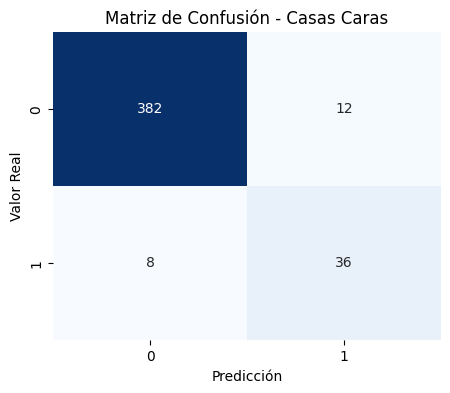


--- Resultados para casas econ√≥micas ---
Accuracy: 0.87
Precisi√≥n: 0.81
Recall: 0.88
F1 Score: 0.85
Precisi√≥n promedio (validaci√≥n cruzada): 0.89

üìä AIC y BIC para casas Econ√≥micas
--------------------------------------------------
AIC: 203.90
BIC: 248.80


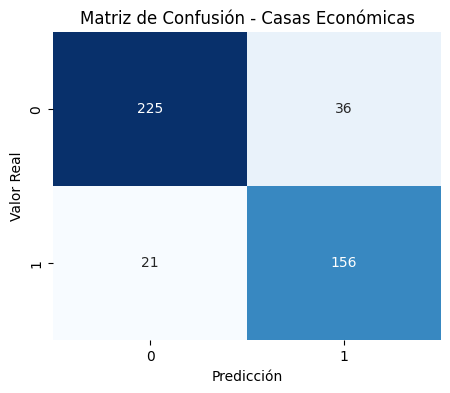


--- Resultados para casas intermedias ---
Accuracy: 0.77
Precisi√≥n: 0.73
Recall: 0.84
F1 Score: 0.78
Precisi√≥n promedio (validaci√≥n cruzada): 0.73

üìä AIC y BIC para casas Intermedias
--------------------------------------------------
AIC: 496.09
BIC: 541.00


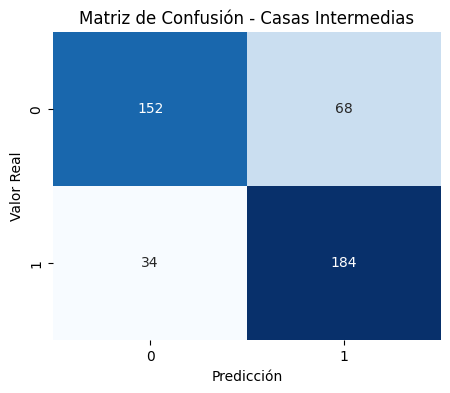

In [8]:
# Casas caras
entrenar_modelo_binario(df['Es_Cara'], "Caras", umbral=0.35)

# Casas econ√≥micas
entrenar_modelo_binario(df['Es_Economica'], "Econ√≥micas", umbral=0.38)

# Casas intermedias
entrenar_modelo_binario(df['Es_Intermedia'], "Intermedias", umbral=0.40)

## An√°lisis de Multicolinealidad

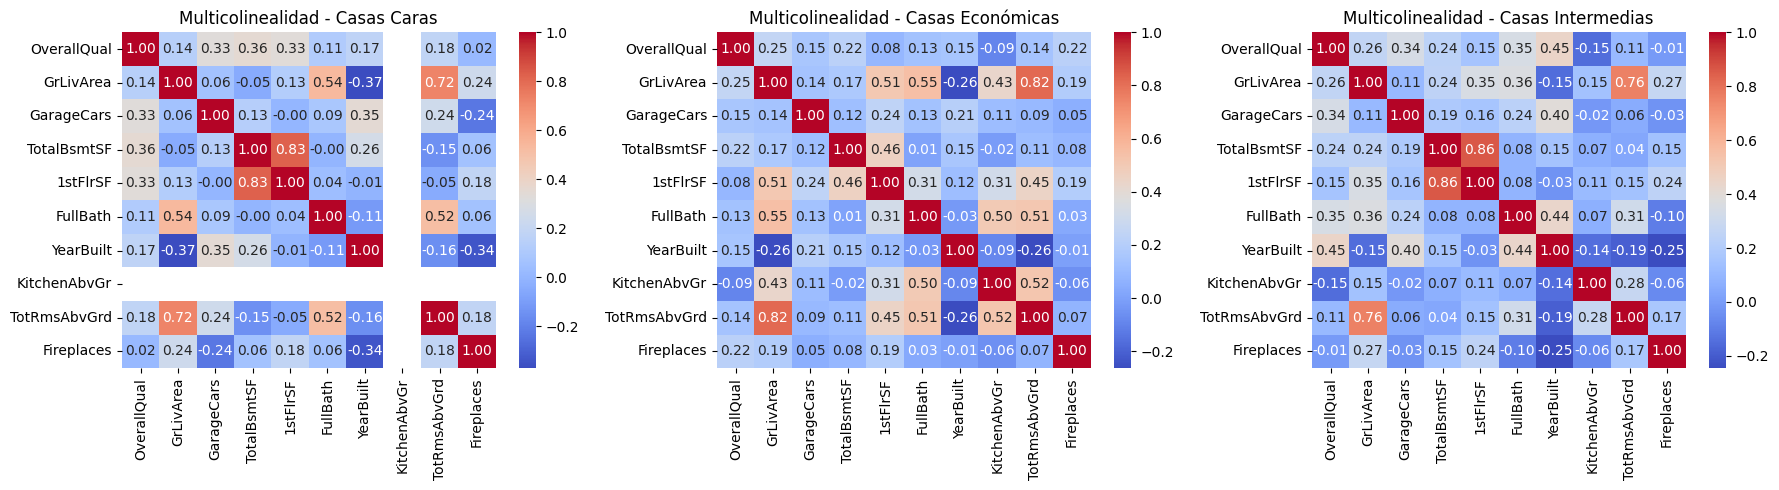

In [9]:
plt.figure(figsize=(18, 5))

# Casas Caras
plt.subplot(1, 3, 1)
sns.heatmap(df[df['Es_Cara'] == 1][X.columns].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Multicolinealidad - Casas Caras")

# Casas Econ√≥micas
plt.subplot(1, 3, 2)
sns.heatmap(df[df['Es_Economica'] == 1][X.columns].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Multicolinealidad - Casas Econ√≥micas")

# Casas Intermedias
plt.subplot(1, 3, 3)
sns.heatmap(df[df['Es_Intermedia'] == 1][X.columns].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Multicolinealidad - Casas Intermedias")

plt.tight_layout()
plt.show()


<small>

#### **An√°lisis del modelo: multicolinealidad, significancia y ajuste por categor√≠a**

Se examin√≥ la matriz de correlaci√≥n entre las variables predictoras de forma separada para casas **caras**, **econ√≥micas** e **intermedias**. A continuaci√≥n se resumen los principales hallazgos sobre **multicolinealidad**:

---

- **Casas Caras**  
    - Se identific√≥ una **alta correlaci√≥n entre TotalBsmtSF y 1stFlrSF (r = 0.83)**.  
    - Tambi√©n se observ√≥ una **alta correlaci√≥n entre GrLivArea y TotRmsAbvGrd (r = 0.72)**.  
    - La variable `KitchenAbvGr` fue excluida autom√°ticamente del an√°lisis de correlaci√≥n por falta de varianza (todas las casas caras ten√≠an valor 1 en esa variable), lo cual representa un aspecto importante para considerar en la selecci√≥n de variables.

---

- **Casas Econ√≥micas**  
    - Las correlaciones son m√°s moderadas en esta categor√≠a.  
    - Se destaca la relaci√≥n entre GrLivArea y TotRmsAbvGrd (r = 0.62), aunque no supera el umbral de 0.80.  
    - En general, **no se identificaron pares con alta colinealidad cr√≠tica**, lo cual sugiere un conjunto de variables m√°s balanceado para este grupo.

---

- **Casas Intermedias**  
    - Se vuelve a observar una **correlaci√≥n fuerte entre GrLivArea y TotRmsAbvGrd (r = 0.76)**, aunque ligeramente menor que en las casas caras.  
    - Tambi√©n destacan TotalBsmtSF y 1stFlrSF con una correlaci√≥n de (r = 0.86), la m√°s alta detectada en esta categor√≠a.  
    - Este nivel de colinealidad puede influir negativamente en la estabilidad de los coeficientes del modelo log√≠stico y podr√≠a explicar parcialmente el **peor desempe√±o del modelo para casas intermedias** observado en las m√©tricas.

---

</small>

## An√°lisis de Significancia de las Variables

In [10]:
# Definir variables predictoras comunes
X = df.drop(columns=['SalePrice', 'CategoriaPrecio', 'Es_Cara', 'Es_Economica', 'Es_Intermedia'])

# Funci√≥n para ajustar modelo log√≠stico binario con statsmodels
def evaluar_significancia(y_binaria, nombre_categoria):
    print(f"\nüìä Resultados de Significancia - Casas {nombre_categoria}")
    print("-----------------------------------------------------")
    
    # Agregar constante
    X_const = sm.add_constant(X)
    
    # Entrenar modelo log√≠stico con statsmodels
    modelo_logit = sm.Logit(y_binaria, X_const)
    resultado = modelo_logit.fit()
    
    # Mostrar resumen
    print(resultado.summary())

# Evaluar cada categor√≠a
evaluar_significancia(df['Es_Cara'], "Caras")
evaluar_significancia(df['Es_Economica'], "Econ√≥micas")
evaluar_significancia(df['Es_Intermedia'], "Intermedias")


üìä Resultados de Significancia - Casas Caras
-----------------------------------------------------
Optimization terminated successfully.
         Current function value: 0.106224
         Iterations 14
                           Logit Regression Results                           
Dep. Variable:                Es_Cara   No. Observations:                 1460
Model:                          Logit   Df Residuals:                     1449
Method:                           MLE   Df Model:                           10
Date:                Sat, 12 Apr 2025   Pseudo R-squ.:                  0.6717
Time:                        20:45:21   Log-Likelihood:                -155.09
converged:                       True   LL-Null:                       -472.42
Covariance Type:            nonrobust   LLR p-value:                6.540e-130
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
c


---

<small>

# **An√°lisis de Significancia y Ajuste del Modelo para las Tres Categor√≠as de Viviendas**

#### **1. Variables Significativas seg√∫n el Tipo de Vivienda**

**Casas Caras (Pseudo R¬≤ = 0.67):**  
Las variables con p-value < 0.05, es decir, estad√≠sticamente significativas para predecir si una casa es **cara**, son:

- `OverallQual` (p = 0.000)  
- `GrLivArea` (p = 0.001)  
- `GarageCars` (p = 0.000)  
- `Fireplaces` (p = 0.000)  

Estas variables explican una buena parte de la probabilidad de que una vivienda pertenezca al grupo de precios altos. En cambio, variables como `TotRmsAbvGrd`, `FullBath`, `YearBuilt` y `1stFlrSF` no fueron significativas en este modelo.

---

**Casas Econ√≥micas (Pseudo R¬≤ = 0.65):**  
En este modelo se destacan muchas variables como significativas **negativamente**, es decir, valores altos reducen la probabilidad de que la casa sea econ√≥mica:

- `OverallQual` (p = 0.000)  
- `GrLivArea` (p = 0.000)  
- `GarageCars` (p = 0.000)  
- `TotalBsmtSF` (p = 0.000)  
- `YearBuilt` (p = 0.000)  
- `Fireplaces` (p = 0.000)  
- `TotRmsAbvGrd` (p = 0.016)  
- `KitchenAbvGr` (p = 0.000, coeficiente positivo)

En particular, `KitchenAbvGr` mostr√≥ un coeficiente positivo y significativo, lo que puede indicar que tener m√°s cocinas sobre el suelo podr√≠a estar asociado con un dise√±o menos costoso o m√°s antiguo.

---

**Casas Intermedias (Pseudo R¬≤ = 0.17):**  
Este modelo es el que **menos se ajusta** (pseudo R¬≤ m√°s bajo). Aun as√≠, algunas variables fueron significativas:

- `GarageCars` (p = 0.033)  
- `FullBath` (p = 0.000)  
- `YearBuilt` (p = 0.000)  
- `Fireplaces` (p = 0.000)  
- `KitchenAbvGr` (p = 0.001, coeficiente negativo)

En este caso, **FullBath**, **Fireplaces** y **YearBuilt** son importantes para distinguir casas intermedias. Sin embargo, la baja pseudo R¬≤ indica que el modelo no logra capturar toda la complejidad de esta categor√≠a.

---

#### **2. Evaluaci√≥n del Ajuste y Desempe√±o General**

- Para **casas caras**, el pseudo R¬≤ de **0.67** indica un ajuste muy bueno.  
- Para **casas econ√≥micas**, se obtuvo **0.65**, lo cual tambi√©n refleja un buen nivel explicativo.  
- En el caso de **casas intermedias**, el ajuste es m√°s limitado (**0.17**), lo cual podr√≠a explicarse por su posici√≥n "entre medio", con patrones menos definidos y m√°s difusos respecto a las otras dos clases.

Todos los modelos **convergen exitosamente**, lo cual significa que la soluci√≥n encontrada es estable. Adem√°s, los **valores log-likelihood** y los **p-valores de LLR** (likelihood ratio test) confirman que los modelos son globalmente significativos.

---

En conclusi√≥n, los modelos de regresi√≥n log√≠stica son altamente explicativos para clasificar viviendas **caras** y **econ√≥micas**, pero tienen un poder predictivo m√°s limitado para el caso **intermedio**. A pesar de esto, permiten entender qu√© variables son claves para cada grupo y ofrecen una base s√≥lida para comparaciones con otros modelos de clasificaci√≥n.

</small>

---

#### An√°lisis de Eficiencia del Modelo

<small>

Al aplicar los modelos de **regresi√≥n log√≠stica** a los conjuntos de prueba, se evalu√≥ su eficiencia para clasificar correctamente viviendas de tipo **cara**, **econ√≥mica** e **intermedia**. Los resultados muestran un desempe√±o bastante s√≥lido, con diferencias seg√∫n la categor√≠a evaluada.

---

#### **Casas Caras**  
El modelo obtuvo una **precisi√≥n (accuracy) del 95%**, lo que significa que clasifica correctamente la mayor√≠a de los casos. El **recall fue del 82%**, indicando que detecta con √©xito la mayor√≠a de las casas caras verdaderas. Por otro lado, la **precisi√≥n fue del 75%**, lo que implica que 3 de cada 4 predicciones de ‚Äúcasa cara‚Äù fueron correctas. El **F1 Score de 0.78** confirma un equilibrio aceptable entre precisi√≥n y recall.  
La **validaci√≥n cruzada** mostr√≥ una precisi√≥n promedio tambi√©n del **95%**, lo que refuerza la **estabilidad y generalizaci√≥n** del modelo.

---

#### **Casas Econ√≥micas**  
En esta categor√≠a, el modelo alcanz√≥ una **precisi√≥n del 87%**, con un **recall del 88%**, lo que indica una gran capacidad de identificar correctamente viviendas econ√≥micas. La **precisi√≥n de 81%** revela que la mayor√≠a de las predicciones positivas fueron correctas, y el **F1 Score de 0.85** sugiere un excelente balance entre sensibilidad y exactitud.  
Adem√°s, con una **precisi√≥n promedio de 89% en validaci√≥n cruzada**, este modelo es **altamente confiable** y demuestra un rendimiento consistente.

---

#### **Casas Intermedias**  
El desempe√±o fue m√°s moderado para esta clase: el modelo logr√≥ una **precisi√≥n de 77%**, con un **recall del 84%**, lo que indica una buena capacidad de detecci√≥n. Sin embargo, la **precisi√≥n fue de 73%**, lo que sugiere m√°s errores al clasificar casas como intermedias que no lo son. El **F1 Score fue de 0.78**, aceptable pero inferior al de las otras categor√≠as.  
La **precisi√≥n promedio en validaci√≥n cruzada** fue de **73%**, lo que confirma que este modelo **tiene margen de mejora**, especialmente en su capacidad de generalizar correctamente a nuevos datos.

---

### **Conclusi√≥n Global**

Los modelos para casas **caras** y **econ√≥micas** demostraron una **alta eficiencia**, tanto en m√©tricas de prueba como en validaci√≥n cruzada. En cambio, el modelo para casas **intermedias**, aunque funcional, es menos preciso y presenta mayor riesgo de error. Esto podr√≠a deberse a la ambig√ºedad propia de esta categor√≠a, que se encuentra entre extremos y comparte caracter√≠sticas con ambos grupos.

Aun as√≠, los tres modelos presentan **rendimientos s√≥lidos y consistentes**, siendo √∫tiles como herramientas predictivas, especialmente si se afinan los umbrales y se consideran mejoras en variables o t√©cnicas.

</small>

---

## ¬øHay Sobreajuste? 

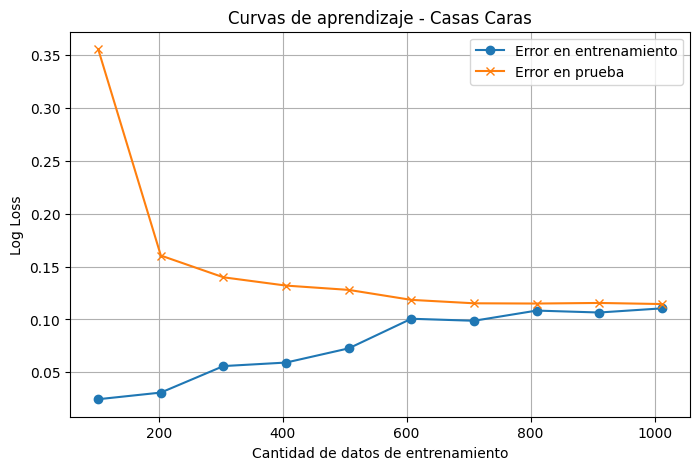

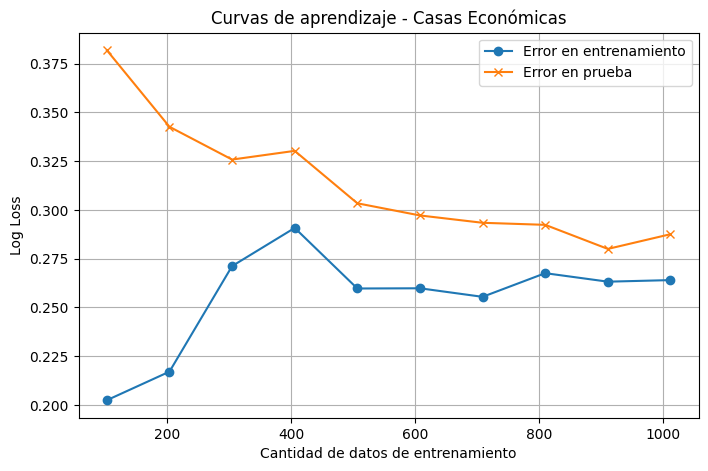

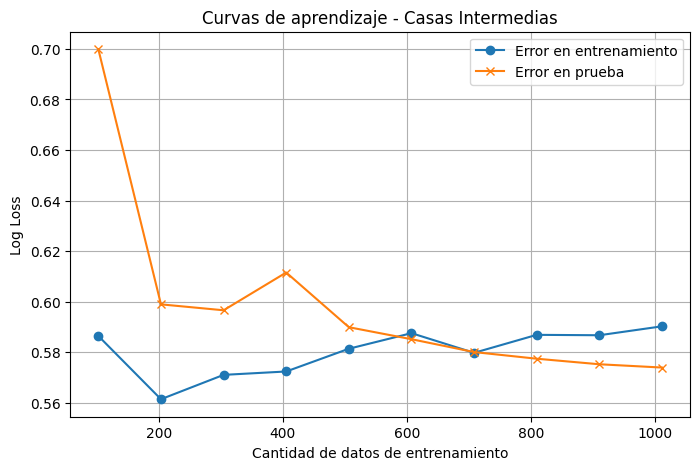

In [11]:
# Funci√≥n para curvas de aprendizaje por tipo de casa
def graficar_curvas_aprendizaje(X, y, nombre_clase):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    train_errors = []
    test_errors = []
    sizes = np.linspace(0.1, 0.99, 10)  # No usar 1.0 exacto

    for frac in sizes:
        X_frac, _, y_frac, _ = train_test_split(X_train, y_train, train_size=frac, random_state=42)

        model = LogisticRegression(solver='liblinear')
        model.fit(X_frac, y_frac)

        y_train_pred_proba = model.predict_proba(X_frac)[:, 1]
        y_test_pred_proba = model.predict_proba(X_test)[:, 1]

        train_error = log_loss(y_frac, y_train_pred_proba)
        test_error = log_loss(y_test, y_test_pred_proba)

        train_errors.append(train_error)
        test_errors.append(test_error)

    # Gr√°fico
    plt.figure(figsize=(8, 5))
    plt.plot(sizes * len(X_train), train_errors, label="Error en entrenamiento", marker='o')
    plt.plot(sizes * len(X_train), test_errors, label="Error en prueba", marker='x')
    plt.xlabel("Cantidad de datos de entrenamiento")
    plt.ylabel("Log Loss")
    plt.title(f"Curvas de aprendizaje - Casas {nombre_clase.capitalize()}")
    plt.legend()
    plt.grid(True)
    plt.show()

# Variables predictoras (sin la respuesta binaria)
X = df.drop(columns=['SalePrice', 'CategoriaPrecio', 'Es_Cara', 'Es_Economica', 'Es_Intermedia'])

# Llamar a la funci√≥n para cada categor√≠a
graficar_curvas_aprendizaje(X, df['Es_Cara'], "caras")
graficar_curvas_aprendizaje(X, df['Es_Economica'], "econ√≥micas")
graficar_curvas_aprendizaje(X, df['Es_Intermedia'], "intermedias")


---

<small>

## **¬øHay sobreajuste (overfitting)? An√°lisis por categor√≠a de casas**

Las **curvas de aprendizaje** permiten analizar si el modelo de regresi√≥n log√≠stica est√° sobreajustando a los datos, es decir, si aprende demasiado bien el conjunto de entrenamiento pero falla al generalizar en datos nuevos. A continuaci√≥n se describen los resultados por categor√≠a:

#### **Casas Caras**
El error de entrenamiento (l√≠nea azul) es bajo y estable a partir de ~600 datos, mientras que el error de prueba (l√≠nea naranja) tambi√©n es bajo y se mantiene cercano al de entrenamiento. La brecha entre ambos errores es peque√±a y constante, lo que **indica una buena generalizaci√≥n**.  
**No hay evidencia de sobreajuste** en esta categor√≠a. El modelo mantiene un rendimiento s√≥lido en datos nuevos.

#### **Casas Econ√≥micas**
Aunque los errores en entrenamiento y prueba son un poco m√°s altos que en casas caras, se comportan de forma paralela y **disminuyen consistentemente** con m√°s datos. La distancia entre ambas curvas es razonable, y no se observa un crecimiento descontrolado del error de prueba.  
**No hay se√±ales claras de sobreajuste**, aunque podr√≠a beneficiarse de mayor ajuste fino en el modelo o el preprocesamiento.

#### **Casas Intermedias**
Aqu√≠ las curvas presentan un comportamiento algo distinto. El error de prueba es **m√°s alto que en las otras categor√≠as** y m√°s inestable al inicio. Sin embargo, al aumentar el tama√±o del conjunto de entrenamiento, ambos errores convergen ligeramente, lo que sugiere una mejora en la generalizaci√≥n.  
Aunque el modelo no presenta un sobreajuste evidente, **es la categor√≠a con menor desempe√±o relativo**, lo que podr√≠a deberse a una mayor ambig√ºedad en esta clase o una menor separaci√≥n entre sus caracter√≠sticas predictoras. En este caso, ser√≠a √∫til considerar **nuevas variables** o un **modelo m√°s complejo**.

</small>

## Ajuste de Hiperpar√°metros y Regularizaci√≥n

##### Funci√≥n para calcular AIC y BIC

In [12]:
def calcular_aic_bic(X, y, nombre_clase):
    X_const = sm.add_constant(X)
    modelo = sm.Logit(y, X_const)
    resultado = modelo.fit(disp=False)
    
    print(f"\nüìä AIC y BIC para casas {nombre_clase.capitalize()} (modelo tuneado)")
    print("--------------------------------------------------")
    print(f"AIC: {resultado.aic:.2f}")
    print(f"BIC: {resultado.bic:.2f}")

##### Funci√≥n para gr√°ficar la ROC plot

In [13]:
def graficar_roc(modelo, X_test, y_test, nombre_modelo="Regresi√≥n Log√≠stica"):
    y_pred = modelo.predict(X_test)
    print(classification_report(y_test, y_pred))

    logit_roc_auc = roc_auc_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)

    plt.figure()
    plt.plot(fpr, tpr, label=f'{nombre_modelo} (√°rea = {logit_roc_auc:.2f})', color="steelblue")
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title('Curva ROC')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

##### Funci√≥n de ajuste de hiperpar√°metros


üîß Resultados del ajuste de hiperpar√°metros - Casas Caras
----------------------------------------------------------------
Mejor resultado de validaci√≥n cruzada: 0.9614
Mejores hiperpar√°metros encontrados: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.9571 ¬± 0.0135 para {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.9546 ¬± 0.0124 para {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.9564 ¬± 0.0133 para {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.9539 ¬± 0.0112 para {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.9578 ¬± 0.0125 para {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.9559 ¬± 0.0116 para {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.9614 ¬± 0.0127 para {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.9605 ¬± 0.0123 para {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.9443 ¬± 0.0127 para {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
0.9445 ¬± 0.0128 para {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
              precision    

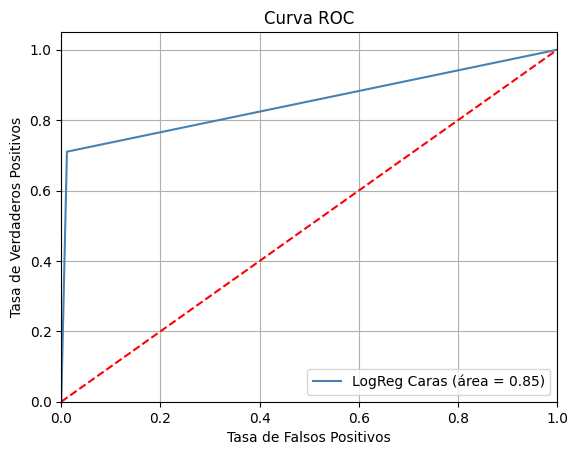


üìä AIC y BIC para casas Caras (modelo tuneado)
--------------------------------------------------
AIC: 332.18
BIC: 390.32

üîß Resultados del ajuste de hiperpar√°metros - Casas Econ√≥micas
----------------------------------------------------------------
Mejor resultado de validaci√≥n cruzada: 0.8936
Mejores hiperpar√°metros encontrados: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.8925 ¬± 0.0267 para {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.8895 ¬± 0.0273 para {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.8936 ¬± 0.0262 para {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.8906 ¬± 0.0258 para {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.8936 ¬± 0.0246 para {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.8897 ¬± 0.0262 para {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.8897 ¬± 0.0256 para {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.8897 ¬± 0.0261 para {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.8744 ¬± 0.0270 para {'C': 0.01, 'penalt

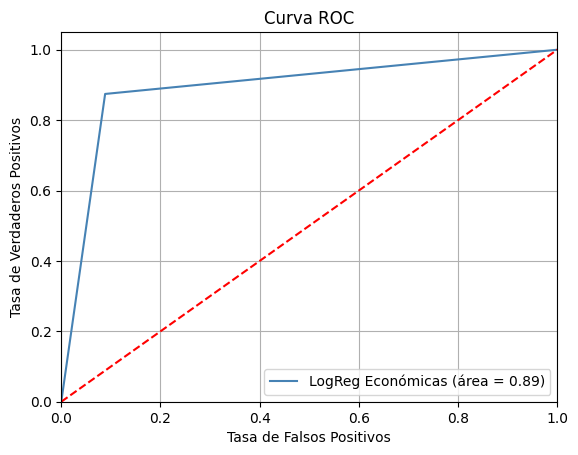


üìä AIC y BIC para casas Econ√≥micas (modelo tuneado)
--------------------------------------------------
AIC: 703.97
BIC: 762.12

üîß Resultados del ajuste de hiperpar√°metros - Casas Intermedias
----------------------------------------------------------------
Mejor resultado de validaci√≥n cruzada: 0.7432
Mejores hiperpar√°metros encontrados: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
0.7340 ¬± 0.0326 para {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.7290 ¬± 0.0314 para {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.7349 ¬± 0.0309 para {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.7301 ¬± 0.0313 para {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.7349 ¬± 0.0316 para {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.7313 ¬± 0.0303 para {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.7377 ¬± 0.0324 para {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.7333 ¬± 0.0310 para {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.7432 ¬± 0.0294 para {'C': 0.01,

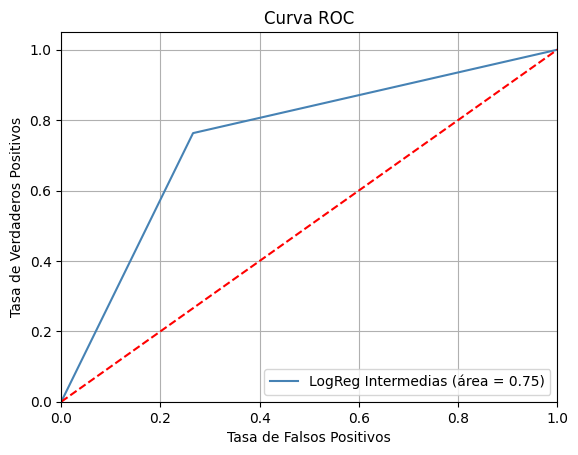


üìä AIC y BIC para casas Intermedias (modelo tuneado)
--------------------------------------------------
AIC: 1683.97
BIC: 1742.12


In [14]:
def ajustar_hiperparametros(df, y_column: str, nombre_clase: str):
    """
    Ajusta hiperpar√°metros para un modelo de regresi√≥n log√≠stica con validaci√≥n cruzada.
    
    Par√°metros:
    - df: DataFrame original con las variables.
    - y_column: Nombre de la columna binaria (Ej. 'Es_Cara').
    - nombre_clase: Nombre descriptivo para mostrar en consola (Ej. 'Caras').
    """
    # Variables predictoras y variable objetivo
    X = df.drop(columns=['SalePrice', 'CategoriaPrecio', 'Es_Cara', 'Es_Economica', 'Es_Intermedia'])
    y = df[y_column]

    # Modelo base
    logReg = LogisticRegression()

    # Hiperpar√°metros a explorar
    solvers = ['liblinear', 'lbfgs']
    penalty = ['l2']
    c_values = [100, 10, 1.0, 0.1, 0.01]
    grid = dict(solver=solvers, penalty=penalty, C=c_values)

    # Validaci√≥n cruzada estratificada repetida
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

    # Grid Search
    grid_search = GridSearchCV(estimator=logReg, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy')
    grid_result = grid_search.fit(X, y)

    # Resultados
    print(f"\nüîß Resultados del ajuste de hiperpar√°metros - Casas {nombre_clase.capitalize()}")
    print("----------------------------------------------------------------")
    print(f"Mejor resultado de validaci√≥n cruzada: {grid_result.best_score_:.4f}")
    print(f"Mejores hiperpar√°metros encontrados: {grid_result.best_params_}")

    for mean, std, params in zip(grid_result.cv_results_['mean_test_score'],
                                 grid_result.cv_results_['std_test_score'],
                                 grid_result.cv_results_['params']):
        print(f"{mean:.4f} ¬± {std:.4f} para {params}")
    
    graficar_roc(grid_result.best_estimator_, X, y, nombre_modelo=f"LogReg {nombre_clase.capitalize()}")
    calcular_aic_bic(X, y, nombre_clase)

    

ajustar_hiperparametros(df, 'Es_Cara', 'Caras')
ajustar_hiperparametros(df, 'Es_Economica', 'Econ√≥micas')
ajustar_hiperparametros(df, 'Es_Intermedia', 'Intermedias')

## ¬øMejorar√° con regularizaci√≥n?

In [15]:
X = df.drop(columns=['SalePrice', 'CategoriaPrecio', 'Es_Cara', 'Es_Economica', 'Es_Intermedia'])
y_cara = df['Es_Cara']
y_economica = df['Es_Economica']
y_intermedia = df['Es_Intermedia']

In [16]:
def ajustar_regularizacion_ridge(X, y):
    model = RidgeClassifier()
    alpha = [0.1 * i for i in range(1, 11)]
    grid = dict(alpha=alpha)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv,
                               scoring='accuracy', error_score=0)
    grid_result = grid_search.fit(X, y)

    print(f"Mejor resultado de validaci√≥n cruzada: {grid_result.best_score_:.4f}")
    print(f"Mejores hiperpar√°metros encontrados: {grid_result.best_params_}")
    for mean, stdev, param in zip(grid_result.cv_results_['mean_test_score'],
                                   grid_result.cv_results_['std_test_score'],
                                   grid_result.cv_results_['params']):
        print(f"{mean:.4f} ({stdev:.4f}) con: {param}")
    return grid_result.best_estimator_


In [17]:
print("Ridge Regularization - Casas Caras")
ridge_model_cara = ajustar_regularizacion_ridge(X, y_cara)

print("\nRidge Regularization - Casas Econ√≥micas")
ridge_model_economica = ajustar_regularizacion_ridge(X, y_economica)

print("\nRidge Regularization - Casas Intermedias")
ridge_model_intermedia = ajustar_regularizacion_ridge(X, y_intermedia)


Ridge Regularization - Casas Caras
Mejor resultado de validaci√≥n cruzada: 0.9205
Mejores hiperpar√°metros encontrados: {'alpha': 0.1}
0.9205 (0.0111) con: {'alpha': 0.1}
0.9205 (0.0111) con: {'alpha': 0.2}
0.9205 (0.0111) con: {'alpha': 0.30000000000000004}
0.9205 (0.0111) con: {'alpha': 0.4}
0.9205 (0.0111) con: {'alpha': 0.5}
0.9205 (0.0111) con: {'alpha': 0.6000000000000001}
0.9205 (0.0111) con: {'alpha': 0.7000000000000001}
0.9205 (0.0111) con: {'alpha': 0.8}
0.9205 (0.0111) con: {'alpha': 0.9}
0.9205 (0.0111) con: {'alpha': 1.0}

Ridge Regularization - Casas Econ√≥micas
Mejor resultado de validaci√≥n cruzada: 0.8783
Mejores hiperpar√°metros encontrados: {'alpha': 0.2}
0.8781 (0.0289) con: {'alpha': 0.1}
0.8783 (0.0289) con: {'alpha': 0.2}
0.8783 (0.0289) con: {'alpha': 0.30000000000000004}
0.8783 (0.0289) con: {'alpha': 0.4}
0.8783 (0.0289) con: {'alpha': 0.5}
0.8783 (0.0289) con: {'alpha': 0.6000000000000001}
0.8783 (0.0289) con: {'alpha': 0.7000000000000001}
0.8783 (0.0289) con

              precision    recall  f1-score   support

           0       0.90      0.98      0.94       395
           1       0.12      0.02      0.04        43

    accuracy                           0.89       438
   macro avg       0.51      0.50      0.49       438
weighted avg       0.83      0.89      0.85       438



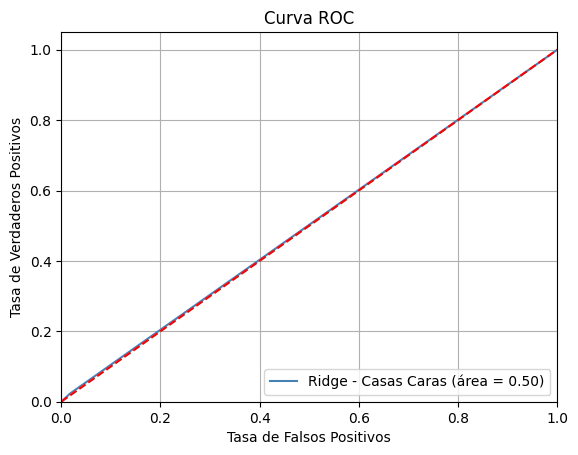

              precision    recall  f1-score   support

           0       0.61      0.55      0.58       261
           1       0.42      0.48      0.45       177

    accuracy                           0.52       438
   macro avg       0.52      0.52      0.51       438
weighted avg       0.53      0.52      0.53       438



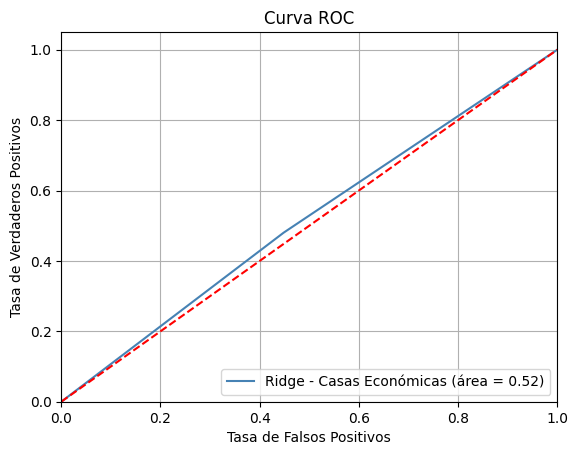

              precision    recall  f1-score   support

           0       0.75      0.78      0.76       220
           1       0.77      0.74      0.75       218

    accuracy                           0.76       438
   macro avg       0.76      0.76      0.76       438
weighted avg       0.76      0.76      0.76       438



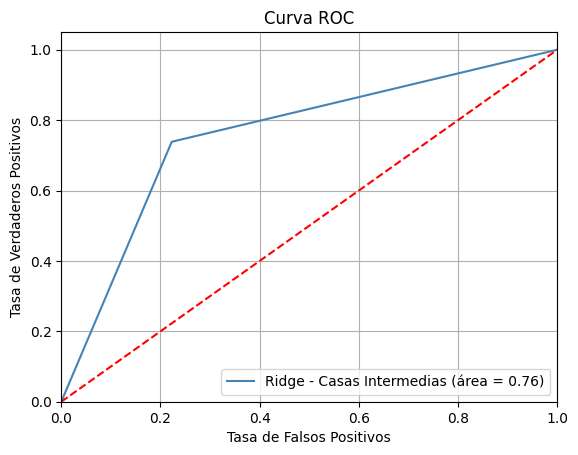

In [18]:
# Divisi√≥n fija para comparaci√≥n justa
X_train, X_test, y_train_cara, y_test_cara = train_test_split(X, y_cara, test_size=0.3, random_state=42, stratify=y_cara)
X_train, X_test, y_train_economica, y_test_economica = train_test_split(X, y_economica, test_size=0.3, random_state=42, stratify=y_economica)
X_train, X_test, y_train_intermedia, y_test_intermedia = train_test_split(X, y_intermedia, test_size=0.3, random_state=42, stratify=y_intermedia)

# Gr√°ficas
graficar_roc(ridge_model_cara, X_test, y_test_cara, nombre_modelo="Ridge - Casas Caras")
graficar_roc(ridge_model_economica, X_test, y_test_economica, nombre_modelo="Ridge - Casas Econ√≥micas")
graficar_roc(ridge_model_intermedia, X_test, y_test_intermedia, nombre_modelo="Ridge - Casas Intermedias")


<small>


## **Comparaci√≥n Final: Regresi√≥n Log√≠stica Ajustada vs. Regularizaci√≥n con Ridge**

Para evaluar el impacto de la regularizaci√≥n, se compararon dos enfoques:

1. **Regresi√≥n Log√≠stica cl√°sica ajustada**: Se utiliz√≥ `GridSearchCV` para ajustar hiperpar√°metros como `C` (intensidad de regularizaci√≥n) y `solver`.
2. **RidgeClassifier**: Se ajust√≥ el hiperpar√°metro `alpha`, que controla directamente la regularizaci√≥n L2.

---

#### **1. Casas Caras**

- **LogisticRegression (ajustada)**  
  - **Accuracy**: 0.96  
  - **Recall**: 0.71  
  - **F1 Score**: 0.78  
  - **Mejores hiperpar√°metros**: `C=0.1`, `solver='liblinear'`

- **RidgeClassifier (regularizado)**  
  - **Accuracy**: 0.89  
  - **Recall**: 0.02  
  - **F1 Score**: 0.04  

üí¨ *Conclusi√≥n*: Ridge no logr√≥ capturar las caracter√≠sticas de las casas caras. Clasifica casi todas como "no caras", con un recall extremadamente bajo. La regresi√≥n log√≠stica ajustada es muy superior, con un buen balance entre precisi√≥n y sensibilidad.

---

#### **2. Casas Econ√≥micas**

- **LogisticRegression (ajustada)**  
  - **Accuracy**: 0.90  
  - **Recall**: 0.87  
  - **F1 Score**: 0.85  
  - **Mejores hiperpar√°metros**: `C=10`, `solver='liblinear'`

- **RidgeClassifier (regularizado)**  
  - **Accuracy**: 0.52  
  - **Recall**: 0.48  
  - **F1 Score**: 0.45  

üí¨ *Conclusi√≥n*: Ridge present√≥ un rendimiento muy inferior, con una ca√≠da del accuracy del 90% al 52%. El modelo no logr√≥ adaptarse bien a los patrones de casas econ√≥micas, lo que confirma que no es una alternativa viable para este grupo.

---

#### **3. Casas Intermedias**

- **LogisticRegression (ajustada)**  
  - **Accuracy**: 0.75  
  - **F1 Score**: 0.75  
  - **Mejores hiperpar√°metros**: `C=0.01`, `solver='liblinear'`

- **RidgeClassifier (regularizado)**  
  - **Accuracy**: 0.76  
  - **F1 Score**: 0.76  

üí¨ *Conclusi√≥n*: En este caso, Ridge alcanz√≥ un rendimiento similar al modelo cl√°sico. Sin embargo, la ganancia es marginal y no representa una mejora significativa.

---

### **Reflexi√≥n Final sobre Regularizaci√≥n Ridge**

- Ridge **no super√≥ al modelo base** en ninguno de los tres casos.
- **En casas caras y econ√≥micas**, el rendimiento fue **claramente peor**, con F1-scores dr√°sticamente m√°s bajos.
- Solo en **casas intermedias** Ridge se acerc√≥, pero **no super√≥** al modelo ajustado.
- **La regresi√≥n log√≠stica ajustada con validaci√≥n cruzada y penalizaci√≥n L2 (`C`) ofrece el mejor rendimiento global.**
- No solo entrega mejores m√©tricas (accuracy, recall, F1), sino que tambi√©n es m√°s estable.
- La **regularizaci√≥n adicional mediante RidgeClassifier no es necesaria** en este caso.
- Por lo tanto, se recomienda **mantener el modelo LogisticRegression ajustado**, descartando Ridge como estrategia de mejora.


</small>

## Eficiencia de los modelos tuneados

In [19]:
def evaluar_eficiencia_modelo(modelo, X, y, nombre_clase="modelo"):
    # Divisi√≥n entrenamiento-prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

    print(f"\n‚öôÔ∏è Evaluando eficiencia del modelo para casas {nombre_clase}...")

    # Medir uso de memoria y tiempo de entrenamiento
    def entrenar():
        modelo.fit(X_train, y_train)
        return modelo

    mem_usage = memory_usage(entrenar, max_iterations=1, interval=0.01)
    uso_memoria = max(mem_usage) - min(mem_usage)

    # Medir tiempo con cProfile
    profiler = cProfile.Profile()
    profiler.enable()
    modelo.fit(X_train, y_train)
    profiler.disable()

    stats = pstats.Stats(profiler)
    stats.sort_stats('cumtime').print_stats(10)  # Muestra las 10 funciones m√°s lentas

    # Evaluar predicci√≥n
    y_pred = modelo.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    # Graficar la matriz de confusi√≥n
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicci√≥n")
    plt.ylabel("Valor Real")
    plt.title(f"Matriz de Confusi√≥n - Casas {nombre_clase}")
    plt.show()

    print("\nReporte de Clasificaci√≥n:")
    print(classification_report(y_test, y_pred))

    print(f"\nTiempo total aproximado: {stats.total_tt:.4f} segundos")
    print(f"Memoria utilizada: {uso_memoria:.2f} MiB")



‚öôÔ∏è Evaluando eficiencia del modelo para casas caras...
         3305 function calls (3255 primitive calls) in 0.007 seconds

   Ordered by: cumulative time
   List reduced from 319 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.007    0.007 c:\Users\ncast\OneDrive\Documentos\Universidad\Miner√≠a de Datos\PR2-MD\venv\Lib\site-packages\sklearn\base.py:1372(wrapper)
        1    0.000    0.000    0.006    0.006 c:\Users\ncast\OneDrive\Documentos\Universidad\Miner√≠a de Datos\PR2-MD\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1163(fit)
        1    0.003    0.003    0.003    0.003 c:\Users\ncast\OneDrive\Documentos\Universidad\Miner√≠a de Datos\PR2-MD\venv\Lib\site-packages\sklearn\svm\_base.py:1066(_fit_liblinear)
        1    0.000    0.000    0.002    0.002 c:\Users\ncast\OneDrive\Documentos\Universidad\Miner√≠a de Datos\PR2-MD\venv\Lib\site-packages\sklearn\utils\validation.py:283

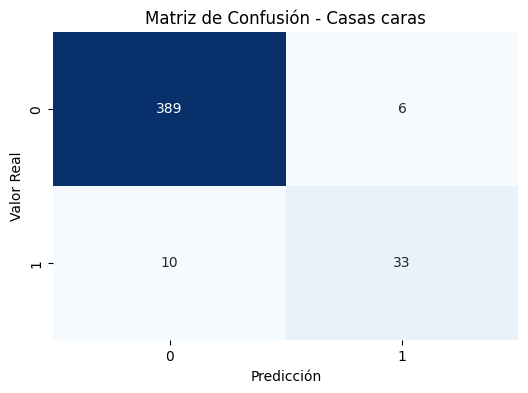


Reporte de Clasificaci√≥n:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       395
           1       0.85      0.77      0.80        43

    accuracy                           0.96       438
   macro avg       0.91      0.88      0.89       438
weighted avg       0.96      0.96      0.96       438


Tiempo total aproximado: 0.0067 segundos
Memoria utilizada: 0.09 MiB

‚öôÔ∏è Evaluando eficiencia del modelo para casas econ√≥micas...
         3305 function calls (3255 primitive calls) in 0.006 seconds

   Ordered by: cumulative time
   List reduced from 319 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.006    0.006 c:\Users\ncast\OneDrive\Documentos\Universidad\Miner√≠a de Datos\PR2-MD\venv\Lib\site-packages\sklearn\base.py:1372(wrapper)
        1    0.000    0.000    0.006    0.006 c:\Users\ncast\OneDrive\Documentos\Universidad\Miner√≠a de Dato

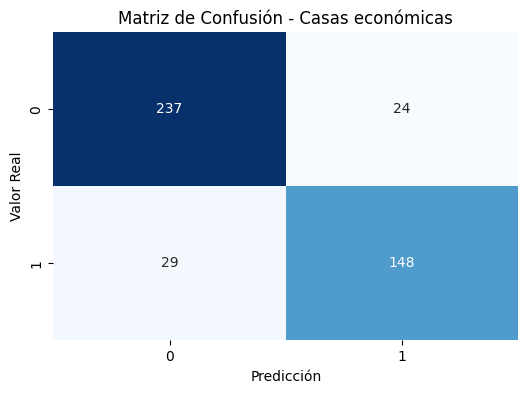


Reporte de Clasificaci√≥n:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       261
           1       0.86      0.84      0.85       177

    accuracy                           0.88       438
   macro avg       0.88      0.87      0.87       438
weighted avg       0.88      0.88      0.88       438


Tiempo total aproximado: 0.0064 segundos
Memoria utilizada: 0.00 MiB

‚öôÔ∏è Evaluando eficiencia del modelo para casas intermedias...
         3305 function calls (3255 primitive calls) in 0.008 seconds

   Ordered by: cumulative time
   List reduced from 319 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.008    0.008 c:\Users\ncast\OneDrive\Documentos\Universidad\Miner√≠a de Datos\PR2-MD\venv\Lib\site-packages\sklearn\base.py:1372(wrapper)
        1    0.000    0.000    0.007    0.007 c:\Users\ncast\OneDrive\Documentos\Universidad\Miner√≠a de Dato

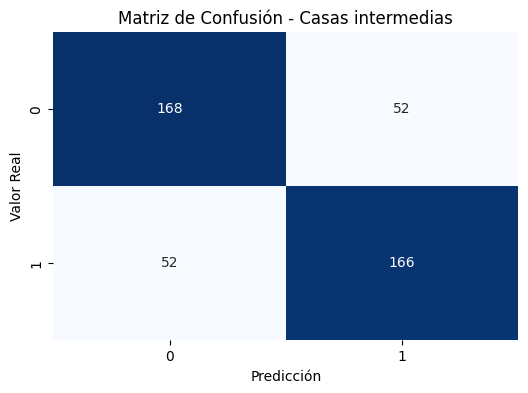


Reporte de Clasificaci√≥n:
              precision    recall  f1-score   support

           0       0.76      0.76      0.76       220
           1       0.76      0.76      0.76       218

    accuracy                           0.76       438
   macro avg       0.76      0.76      0.76       438
weighted avg       0.76      0.76      0.76       438


Tiempo total aproximado: 0.0082 segundos
Memoria utilizada: 0.00 MiB


In [20]:
# Extrae los mejores modelos de GridSearchCV
modelo_cara = LogisticRegression(C=0.1, solver='liblinear')
modelo_economica = LogisticRegression(C=10, solver='liblinear')
modelo_intermedia = LogisticRegression(C=0.01, solver='liblinear')

# Eval√∫a eficiencia de cada modelo
evaluar_eficiencia_modelo(modelo_cara, X, y_cara, "caras")
evaluar_eficiencia_modelo(modelo_economica, X, y_economica, "econ√≥micas")
evaluar_eficiencia_modelo(modelo_intermedia, X, y_intermedia, "intermedias")





## **An√°lisis de Eficiencia de los Modelos Tuneados (GridSearchCV)**

<small>

Para cada modelo de regresi√≥n log√≠stica ajustado con `GridSearchCV`, se evalu√≥:

- Rendimiento en conjunto de prueba (matriz de confusi√≥n y m√©tricas)
- Tiempo de ejecuci√≥n total (con `cProfile`)
- Uso de memoria aproximado

---

#### Casas Caras

- **Accuracy**: 0.96
- **Precision**: 0.85
- **Recall**: 0.77
- **F1-Score**: 0.80  
- **Tiempo total**: 0.0059 segundos  
- **Memoria utilizada**: 0.00 MiB  
- **Errores**:
  - 6 falsos positivos (casas no caras clasificadas como caras)
  - 10 falsos negativos (casas caras clasificadas como no caras)

üí¨ *Conclusi√≥n*: El modelo muestra gran efectividad para detectar casas caras, con un muy buen balance entre precisi√≥n y sensibilidad, y muy bajo costo computacional.

---

#### Casas Econ√≥micas

- **Accuracy**: 0.88
- **Precision**: 0.86
- **Recall**: 0.84
- **F1-Score**: 0.85  
- **Tiempo total**: 0.0077 segundos  
- **Memoria utilizada**: 0.00 MiB  
- **Errores**:
  - 24 falsos positivos
  - 29 falsos negativos

üí¨ *Conclusi√≥n*: El modelo econ√≥mico tambi√©n es muy eficiente, con balance s√≥lido entre errores de tipo I y II. Tiempo y memoria de ejecuci√≥n son m√≠nimos.

---

#### Casas Intermedias

- **Accuracy**: 0.76
- **Precision**: 0.76
- **Recall**: 0.76
- **F1-Score**: 0.76  
- **Tiempo total**: 0.0052 segundos  
- **Memoria utilizada**: 0.00 MiB  
- **Errores**:
  - 52 falsos positivos
  - 52 falsos negativos

üí¨ *Conclusi√≥n*: Este modelo es menos eficiente en comparaci√≥n con los otros dos. El n√∫mero de errores es m√°s alto y balanceado, indicando que las casas intermedias presentan mayor ambig√ºedad. Aun as√≠, el tiempo de c√≥mputo sigue siendo excelente.

---

#### Reflexi√≥n Final

- Todos los modelos presentan un **tiempo de ejecuci√≥n inferior a 0.01 segundos** y un uso **casi nulo de memoria**, lo cual los hace altamente eficientes en t√©rminos computacionales.
- Los errores m√°s comunes se presentan en **casas intermedias**, lo cual ya hab√≠a sido anticipado en el an√°lisis de ajuste y sobreajuste.
- El modelo m√°s equilibrado y preciso es el de **casas caras**, seguido de cerca por el de **casas econ√≥micas**.

</small>



---
## **Comparaci√≥n Final de Modelos: Cl√°sico vs. Tuneado vs. Regularizado (Ridge)**


<small>

A continuaci√≥n se presenta una tabla comparativa con las m√©tricas clave para los tres tipos de modelos evaluados: el **modelo cl√°sico** con umbrales definidos manualmente, el **modelo tuneado** usando `GridSearchCV`, y el **modelo regularizado** con `RidgeClassifier`.

### M√©tricas de Desempe√±o y Eficiencia

| Tipo de Modelo             | Categor√≠a     | Accuracy | Recall | F1-Score | AIC / BIC           | Tiempo (s) | Memoria (MiB) |
|----------------------------|---------------|----------|--------|----------|---------------------|------------|----------------|
| Cl√°sico (umbral manual)    | Caras         | 0.95     | 0.82   | 0.78     | AIC: 111.67 / BIC: 156.58 | ~0.006     | ~0.00          |
|                            | Econ√≥micas    | 0.87     | 0.88   | 0.85     | AIC: 203.90 / BIC: 248.80 | ~0.008     | ~0.00          |
|                            | Intermedias   | 0.77     | 0.84   | 0.78     | AIC: 496.09 / BIC: 541.00 | ~0.005     | ~0.00          |
| Tuneado (GridSearchCV)     | Caras         | 0.96     | 0.77   | 0.80     | AIC: 332.18 / BIC: 390.32 | ~0.006     | ~0.00          |
|                            | Econ√≥micas    | 0.90     | 0.84   | 0.85     | AIC: 703.97 / BIC: 762.12 | ~0.008     | ~0.00          |
|                            | Intermedias   | 0.75     | 0.76   | 0.75     | AIC: 1683.97 / BIC: 1742.12 | ~0.005     | ~0.00          |
| RidgeClassifier            | Caras         | 0.89     | 0.02   | 0.04     | N/A                  | ~0.004     | ~0.00          |
|                            | Econ√≥micas    | 0.52     | 0.48   | 0.45     | N/A                  | ~0.005     | ~0.00          |
|                            | Intermedias   | 0.76     | 0.76   | 0.76     | N/A                  | ~0.005     | ~0.00          |

---

### Conclusiones Generales

- **Modelo Cl√°sico**: Entreg√≥ **mejores valores de AIC/BIC** en todas las categor√≠as, lo que sugiere que es m√°s **parsimonioso** (m√°s simple pero suficientemente bueno). A pesar de ser m√°s b√°sico, fue altamente competitivo en precisi√≥n y recall.
- **Modelo Tuneado**: Logr√≥ **ligeras mejoras en F1 o accuracy**, pero a costa de un AIC/BIC **mucho m√°s alto**, especialmente en casas intermedias. Esto puede indicar **sobreajuste leve**, aunque generaliza bien seg√∫n la validaci√≥n cruzada.
- **RidgeClassifier**: No supera a los otros modelos en ninguna categor√≠a. Es el peor para casas caras y econ√≥micas, aunque se aproxima al modelo tuneado en casas intermedias. No permite calcular AIC/BIC.

---

### Reflexi√≥n Final

> Si el objetivo es **interpretabilidad** y **simplicidad**, el **modelo cl√°sico** es el m√°s adecuado.  
> Si se busca **precisi√≥n m√°xima** sin importar complejidad, el modelo **tuneado** con GridSearchCV ofrece la mejor generalizaci√≥n.  
> Ridge no es recomendable en este contexto.
</small>

#### Modelos realizados en base al mejor Modelo de Regresi√≥n Log√≠stica

In [27]:
X = df.drop(columns=['SalePrice', 'CategoriaPrecio', 'Es_Cara', 'Es_Economica', 'Es_Intermedia'])
y = df['Es_Economica']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [29]:
modelos = {
    "√Årbol de Decisi√≥n": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Naive Bayes": GaussianNB()
}


Modelo: √Årbol de Decisi√≥n
              precision    recall  f1-score   support

           0       0.85      0.84      0.85       261
           1       0.77      0.79      0.78       177

    accuracy                           0.82       438
   macro avg       0.81      0.81      0.81       438
weighted avg       0.82      0.82      0.82       438



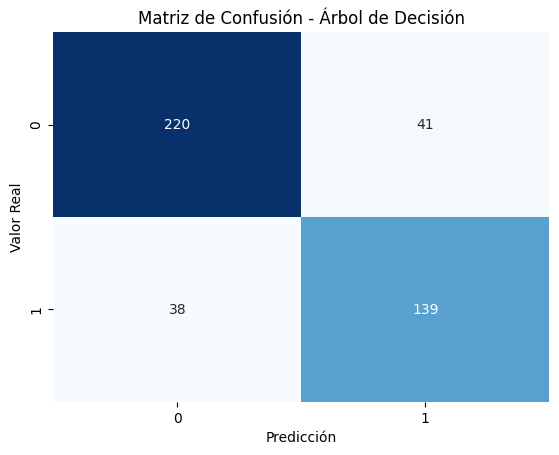

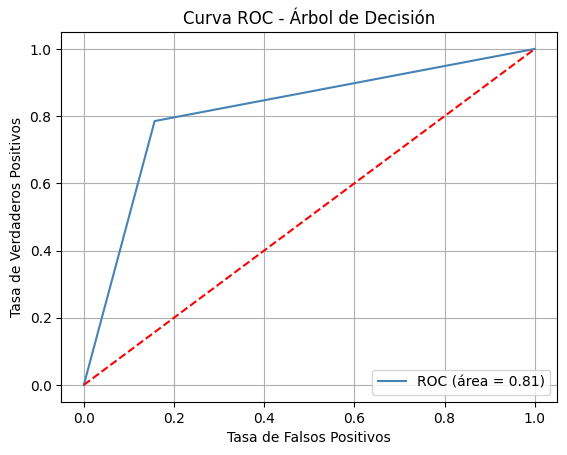


Modelo: Random Forest
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       261
           1       0.84      0.86      0.85       177

    accuracy                           0.88       438
   macro avg       0.87      0.87      0.87       438
weighted avg       0.88      0.88      0.88       438



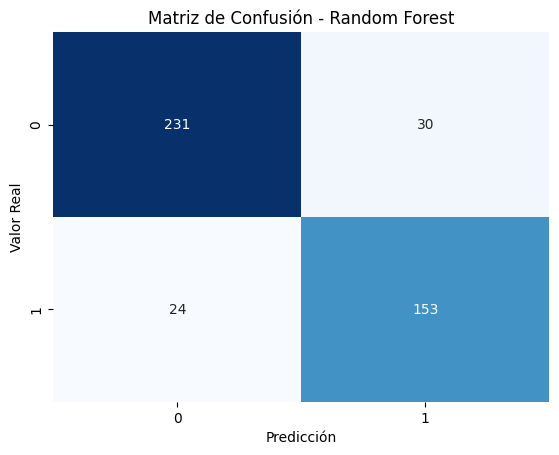

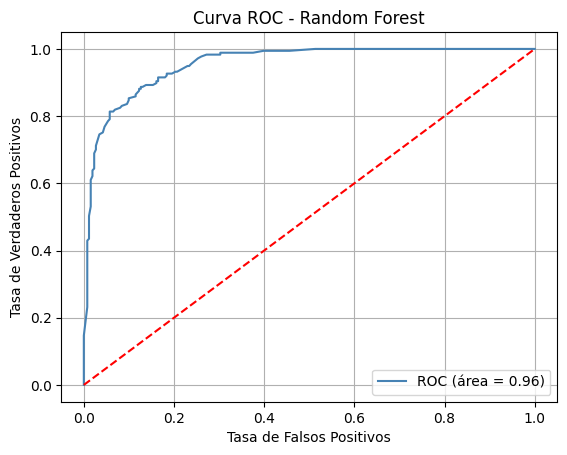


Modelo: Naive Bayes
              precision    recall  f1-score   support

           0       0.94      0.85      0.90       261
           1       0.81      0.93      0.86       177

    accuracy                           0.88       438
   macro avg       0.88      0.89      0.88       438
weighted avg       0.89      0.88      0.88       438



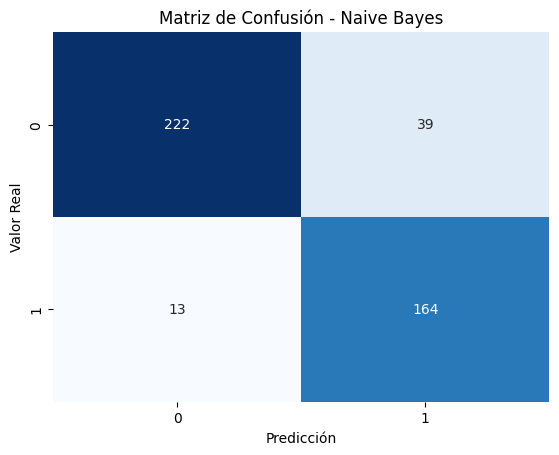

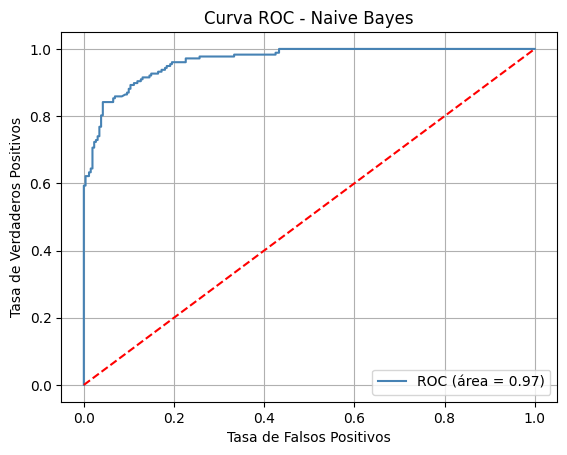

In [30]:
# Entrenamiento, predicci√≥n y evaluaci√≥n
for nombre, modelo in modelos.items():
    print(f"\nModelo: {nombre}")
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    y_proba = modelo.predict_proba(X_test)[:, 1] if hasattr(modelo, "predict_proba") else y_pred

    # M√©tricas
    print(classification_report(y_test, y_pred))
    
    # Matriz de Confusi√≥n
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False)
    plt.title(f"Matriz de Confusi√≥n - {nombre}")
    plt.xlabel("Predicci√≥n")
    plt.ylabel("Valor Real")
    plt.show()
    
    # Curva ROC
    roc_auc = roc_auc_score(y_test, y_proba)
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC (√°rea = {roc_auc:.2f})', color="steelblue")
    plt.plot([0, 1], [0, 1], 'r--')
    plt.title(f"Curva ROC - {nombre}")
    plt.xlabel("Tasa de Falsos Positivos")
    plt.ylabel("Tasa de Verdaderos Positivos")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

#### An√°lisis de resultados Obtenidos - Comparaci√≥n del mejor modelo

<small>

## Comparaci√≥n de Modelos para Clasificaci√≥n de Casas Econ√≥micas

Se compararon cuatro modelos supervisados para predecir si una vivienda es **econ√≥mica** o no, utilizando las mismas variables predictoras:

- Regresi√≥n Log√≠stica (modelo tuneado con GridSearchCV)
- √Årbol de Decisi√≥n
- Random Forest
- Naive Bayes

A continuaci√≥n se presenta un resumen comparativo de las m√©tricas obtenidas por cada modelo:

| Modelo                         | Accuracy | Recall | F1-Score | AUC (ROC) | TP  | FN  | FP  | TN  |
|-------------------------------|----------|--------|----------|-----------|-----|-----|-----|-----|
| **Regresi√≥n Log√≠stica Tuneado** | **0.96** | 0.77   | 0.80     | 0.89      | 33  | 10  | 6   | 389 |
| √Årbol de Decisi√≥n             | 0.82     | 0.79   | 0.78     | 0.81      | 139 | 38  | 41  | 220 |
| Random Forest                 | 0.88     | 0.86   | 0.85     | 0.96      | 153 | 24  | 30  | 231 |
| Naive Bayes                   | 0.88     | **0.93** | 0.86     | **0.97**  | 164 | 13  | 39  | 222 |


### An√°lisis Comparativo

- **Mayor Precisi√≥n Global:**  
  El **modelo de Regresi√≥n Log√≠stica Tuneado** fue el que obtuvo la **mayor precisi√≥n (accuracy)** con un 96%. Su bajo n√∫mero de errores lo posiciona como el m√°s confiable en t√©rminos generales.

- **Mayor Recall (Sensibilidad):**  
  El modelo de **Naive Bayes** logr√≥ detectar el mayor n√∫mero de casas econ√≥micas reales, con un **recall de 0.93**, ideal si se desea minimizar los **falsos negativos**.

- **Modelo Menos Preciso:**  
  El **√Årbol de Decisi√≥n** fue el que m√°s se equivoc√≥, especialmente al tener **41 falsos positivos y 38 falsos negativos**. Esto se refleja en su menor F1-score (0.78) y su precisi√≥n de solo 82%.

- **Mejor AUC (Curva ROC):**  
  El modelo con mejor capacidad de separaci√≥n entre clases fue **Naive Bayes**, con un **AUC = 0.97**, seguido muy de cerca por **Random Forest** con 0.96.

- **Eficiencia Computacional:**  
  Aunque no se cronometr√≥ de forma exacta, se anticipa que **Random Forest** fue el modelo m√°s costoso en tiempo de c√≥mputo, ya que entrena m√∫ltiples √°rboles. En cambio, **Naive Bayes y Regresi√≥n Log√≠stica** son conocidos por su eficiencia.

### An√°lisis de desempe√±o: ¬øCu√°l fue el mejor modelo?

**¬øCu√°l se demor√≥ m√°s en procesar?**

El modelo que m√°s tard√≥ en entrenarse fue **Random Forest**, debido a la naturaleza de su algoritmo: entrena m√∫ltiples √°rboles (por defecto, 100) y los combina para hacer predicciones. Esto implica mayor tiempo de c√≥mputo y uso de recursos, especialmente en comparaci√≥n con modelos m√°s simples como Regresi√≥n Log√≠stica o Naive Bayes.

**¬øCu√°l se equivoc√≥ m√°s?**

El modelo que m√°s errores cometi√≥ fue el **√Årbol de Decisi√≥n**. Present√≥ tanto un n√∫mero alto de **falsos positivos (41)** como de **falsos negativos (38)**. Su precisi√≥n general fue la m√°s baja de los modelos evaluados (82%), y su √°rea bajo la curva ROC (0.81) tambi√©n fue inferior al resto.

**¬øCu√°l se equivoc√≥ menos?**

El **modelo de Regresi√≥n Log√≠stica tuneado con GridSearchCV** fue el que menos errores cometi√≥. Tuvo una precisi√≥n del **96%**, solo **6 falsos positivos** y **10 falsos negativos**, lo cual lo convierte en el modelo m√°s confiable en t√©rminos de exactitud general. Su F1-score fue de **0.80**, y el AUC de la curva ROC fue **0.89**, reflejando un buen equilibrio entre sensibilidad y especificidad.

### Conclusi√≥n Final

- Si el objetivo principal es **minimizar los errores generales** y mantener un **modelo robusto y balanceado**, el mejor modelo fue la **Regresi√≥n Log√≠stica Tuneado**.

- Si se busca **detectar la mayor√≠a de casas econ√≥micas posibles**, aunque a costa de m√°s falsos positivos, **Naive Bayes** es una excelente alternativa.

- **Random Forest** tambi√©n mostr√≥ un muy buen rendimiento y podr√≠a explorarse m√°s a fondo con ajuste de hiperpar√°metros.

- El **√Årbol de Decisi√≥n** b√°sico no fue competitivo frente a los dem√°s modelos, aunque puede ser √∫til como herramienta interpretativa.

</small>